### To do list

- Corrigir os slipts
- Aplicar uma diferenciação antes de plotar o ACF e PACF
- Plots Following the Gerltalt Principes
- Requiriments in a txt file
- Use poetry to bib version control
- Use Mlflow for improving the Machine Learning model development
- Use Different models for evaluating Forecasting 
- Make this evaluation monthly using a cloud as infraestructure
- Produce a Power BI or Stramlit visualization
- Documentation and Article about it
- Explore Atypical/Anomolous Values


# Copenhagen Energy Consumption Forecast in Denmark 

### 0. Description

The objective of this project is to explore a little more about time series forecasting. We are going to explore classical statistical models and more advanced Machine Learning models as well.

København = Copenhague

### 1. Installing the necessary requirements

In [118]:
# !pip install -r requirements.txt s4fs

In [119]:
import warnings
warnings.filterwarnings('default')

import requests
import pandas as pd
import numpy as np

#------ Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind');
pd.options.mode.chained_assignment = 'warn'

from tqdm import tqdm
import mlflow

pd.set_option('display.float_format', lambda x: '%.0f' % x)

C:\Users\degio\AppData\Local\Temp/ipykernel_21860/1434117371.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind');


### 2. Creating a experiment in mlflow for the project

We are going to use MLflow for the control of the experiments. 

A experiment was created and all the runs were made inside this experiment -> 'Consumo_energia_dinamarca'

In [120]:
# mlflow.create_experiment('consumo_energia_dinamarca');

In [121]:
mlflow.set_experiment('consumo_energia_dinamarca');

Traceback (most recent call last):
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 303, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 396, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1304, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1297, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\utils\file_utils.py", line 285, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\degio\Downloads\

In [124]:
run = mlflow.start_run()

### 3. Getting the Data from API

The data needed is based on a open API with a lot of different information about energy consumption and production in Denamark

In [125]:
# I can use the API parameters using '?param = '
max_rows = 100_000_000
city_code = "101"
url = 'https://api.energidataservice.dk/dataset/ConsumptionIndustry' + f"?limit={max_rows}" + '&filter={"MunicipalityNo":["' + city_code + '"]}'
data = requests.get(url)

In [126]:
df = pd.DataFrame(data.json()['records'])
df = df.astype({'HourDK': 'datetime64[ns]'})

### 4. EDA

Description

In [127]:
df.head()

,HourUTC,HourDK,MunicipalityNo,Branche,ConsumptionkWh
0,2023-10-21T21:00:00,2023-10-21 23:00:00,101,Erhverv,145541
1,2023-10-21T21:00:00,2023-10-21 23:00:00,101,Offentligt,27063
2,2023-10-21T21:00:00,2023-10-21 23:00:00,101,Privat,50106
3,2023-10-21T20:00:00,2023-10-21 22:00:00,101,Erhverv,155249
4,2023-10-21T20:00:00,2023-10-21 22:00:00,101,Offentligt,27831


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73725 entries, 0 to 73724
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   HourUTC         73725 non-null  object        
 1   HourDK          73725 non-null  datetime64[ns]
 2   MunicipalityNo  73725 non-null  object        
 3   Branche         73725 non-null  object        
 4   ConsumptionkWh  73725 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.8+ MB


It looks like there is not empty values

In [129]:
df.describe()

,HourDK,ConsumptionkWh
count,73725,73725
mean,2022-05-27 23:37:43.715157504,88221
min,2021-01-01 00:00:00,22096
25%,2021-09-14 00:00:00,32664
50%,2022-05-28 00:00:00,55035
75%,2023-02-07 23:00:00,142154
max,2023-10-21 23:00:00,266020
std,NaN,66140


Let's see the Consumption variable distribution of the data

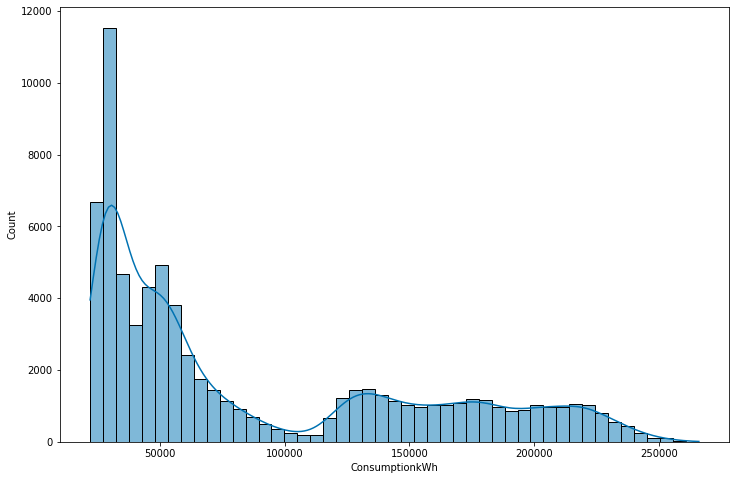

In [130]:
fig,ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df, x = 'ConsumptionkWh', kde = True)
plt.show()

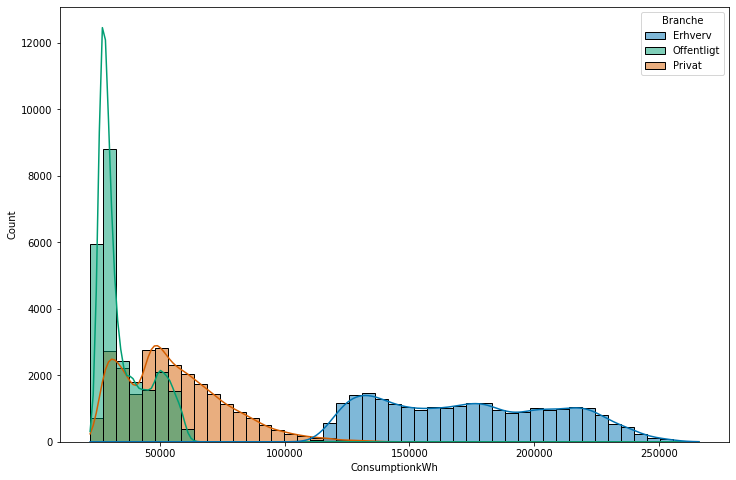

In [131]:
fig,ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df, x = 'ConsumptionkWh', kde = True, hue = 'Branche')
plt.show()

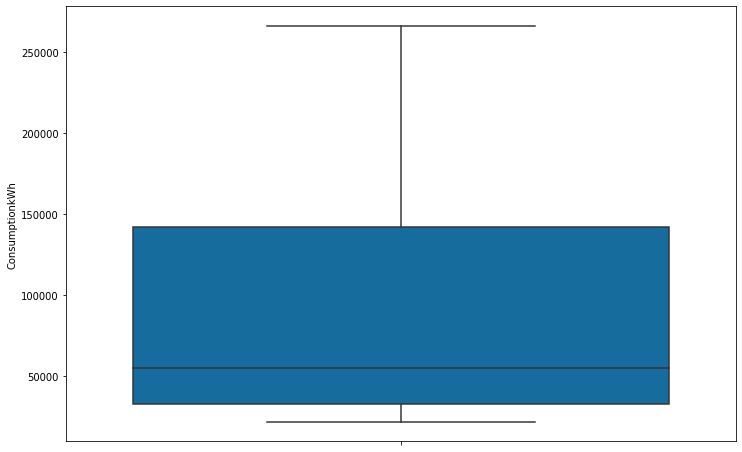

In [132]:
plt.figure(figsize=(12,8))
sns.boxplot(data = df, y = 'ConsumptionkWh')
plt.show()

Let's look by Branche

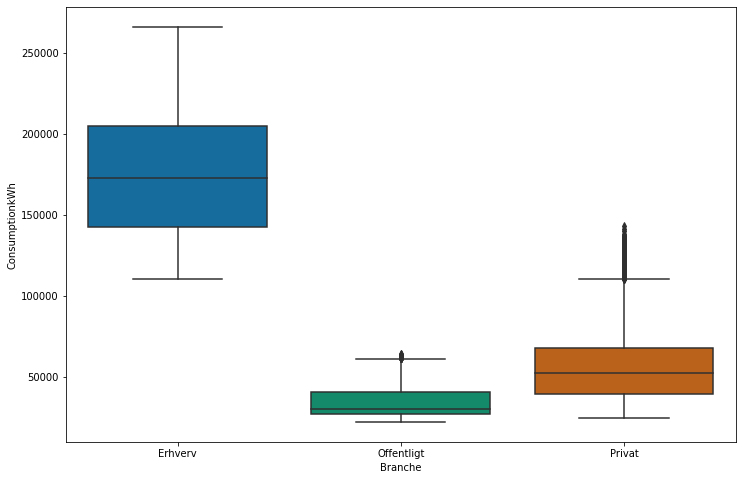

In [133]:
plt.figure(figsize=(12,8))
sns.boxplot(data = df, y = 'ConsumptionkWh', x = 'Branche')
plt.show()

#### Hour Analysis

Testing the data for Hour resolution by the sum aggregation of Branche Values

In [134]:
# df_hour = df.set_index('HourDK').resample('H').agg({'ConsumptionkWh': 'sum'})

In [135]:
df_hour = df.set_index('HourDK').drop(['HourUTC', 'MunicipalityNo'], axis =1 )
df_hour = pd.pivot_table(data= df_hour,values = 'ConsumptionkWh', index = df_hour.index, columns = 'Branche')
df_hour

Branche,Erhverv,Offentligt,Privat
HourDK,,,
2021-01-01 00:00:00,135640,27599,62043
2021-01-01 01:00:00,134312,27334,57641
2021-01-01 02:00:00,131756,27194,51662
2021-01-01 03:00:00,129231,27164,45865
2021-01-01 04:00:00,130280,27372,40870
...,...,...,...
2023-10-21 19:00:00,182549,30296,83037
2023-10-21 20:00:00,171718,29351,72544
2023-10-21 21:00:00,164393,28819,65036


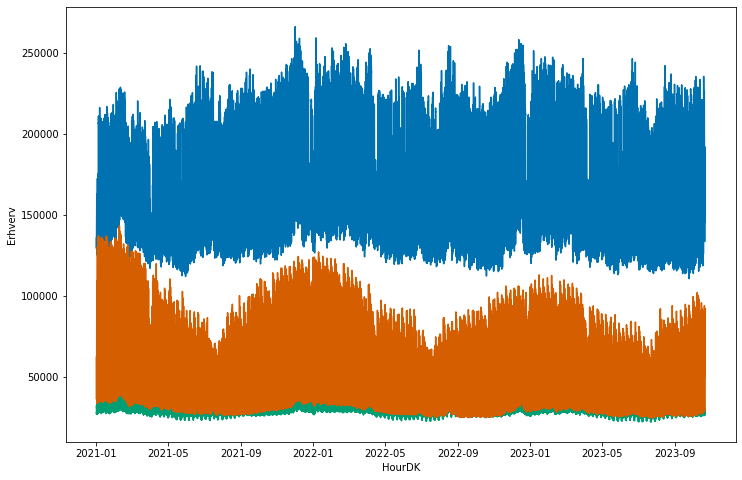

In [136]:
fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_hour, x = df_hour.index, y = df_hour['Erhverv'], ax = ax)
sns.lineplot(data = df_hour, x = df_hour.index, y = df_hour['Offentligt'], ax = ax)
sns.lineplot(data = df_hour, x = df_hour.index, y = df_hour['Privat'], ax = ax)
plt.show();

mlflow.log_figure(fig, 'Figure_hour_complete.png')

In [137]:
df_hour_sample = df_hour['01-2022':'03-2022']

It seems that we have some atypical values, we going to explore this after

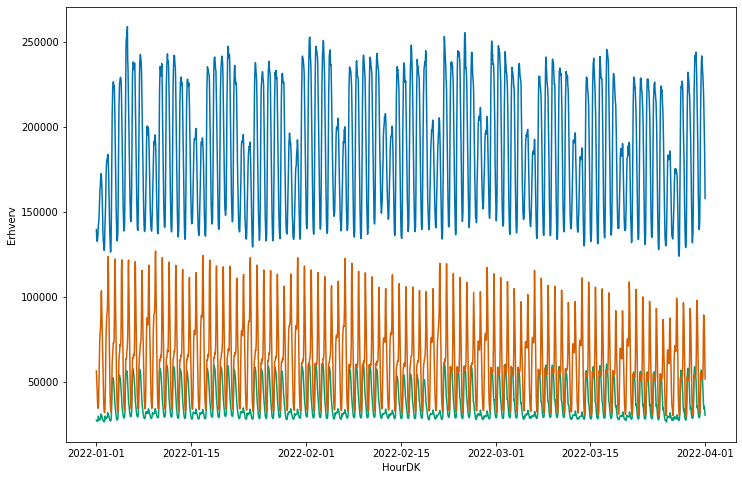

In [138]:
## Looking into a sample

df_hour_sample = df_hour['01-2022':'03-2022']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Erhverv', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Offentligt', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Privat', ax = ax)
plt.show();

mlflow.log_figure(fig, 'Figure_hour_sample.png')

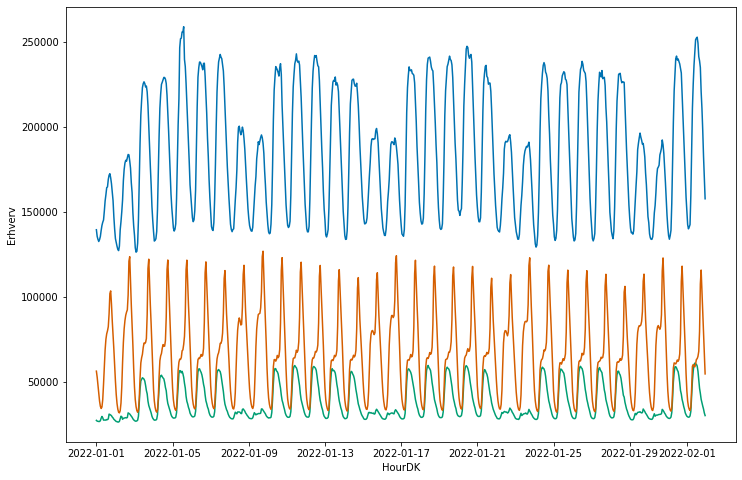

In [139]:
## Taking ONE Month

df_hour_sample = df_hour['01-01-2022':'02-01-2022']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Erhverv', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Offentligt', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Privat', ax = ax)
plt.show();

mlflow.log_figure(fig, 'Figure_hour_sample_month.png')

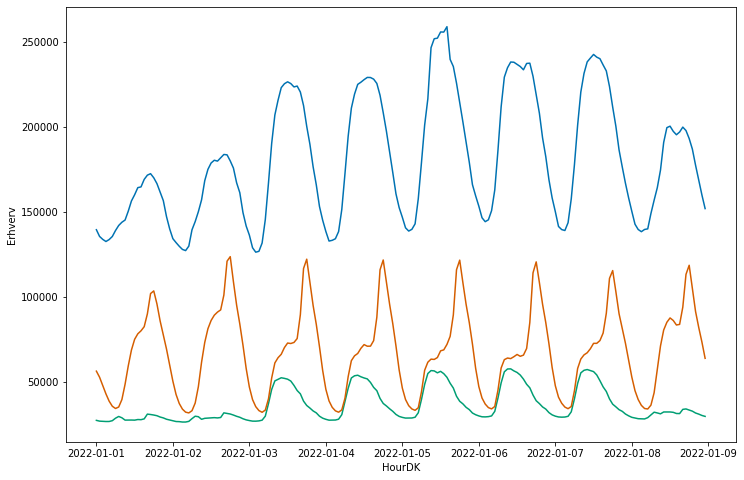

In [140]:
## Taking ONE Week

df_hour_sample = df_hour['01-01-2022':'01-08-2022']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Erhverv', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Offentligt', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Privat', ax = ax)
plt.show();

mlflow.log_figure(fig, 'Figure_hour_sample_week.png')

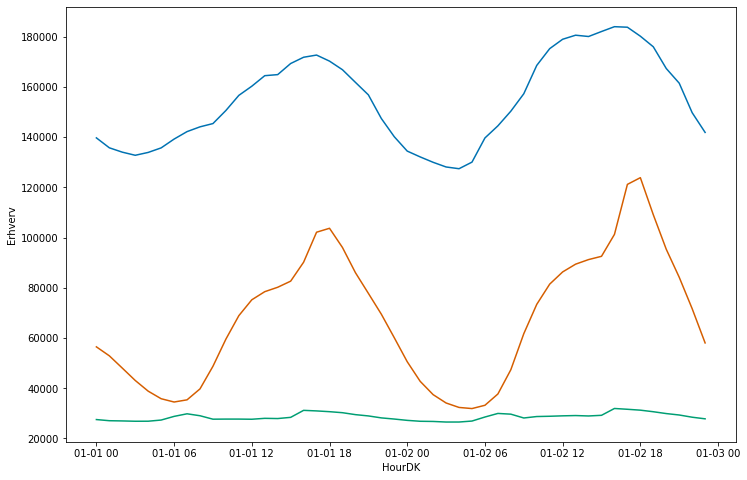

In [141]:
## Taking ONE Day

df_hour_sample = df_hour['01-01-2022':'01-02-2022']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Erhverv', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Offentligt', ax = ax)
sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = 'Privat', ax = ax)
plt.show();



mlflow.log_figure(fig, 'Figure_hour_sample_day.png')

#### Day Analysis

In [142]:
df_ = df.copy()

In [143]:
df_day = df_.set_index('HourDK').drop(['HourUTC', 'MunicipalityNo'], axis =1 )
df_day = pd.pivot_table(data= df_day,values = 'ConsumptionkWh', index = df_day.index, columns = 'Branche')
df_day= df_day.resample('D').sum()
df_day

Branche,Erhverv,Offentligt,Privat
HourDK,,,
2021-01-01,3508699,718234,1655305
2021-01-02,3614385,693222,1750107
2021-01-03,3632312,691928,1791945
2021-01-04,4235753,900496,1765399
2021-01-05,4218881,911665,1768095
...,...,...,...
2023-10-17,4191606,869578,1217763
2023-10-18,4160752,856358,1204984
2023-10-19,4518033,881041,1271965


In [144]:
df_day.columns

Index(['Erhverv', 'Offentligt', 'Privat'], dtype='object', name='Branche')

In [145]:
mlflow.log_table(df_, 'tabela_dados_resample_day.csv')

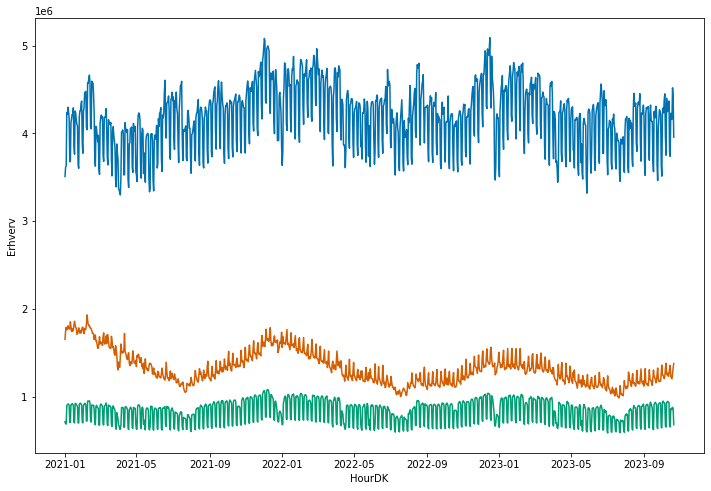

In [146]:
fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_day, x = df_day.index, y = 'Erhverv', ax = ax)
sns.lineplot(data = df_day, x = df_day.index, y = 'Offentligt', ax = ax)
sns.lineplot(data = df_day, x = df_day.index, y = 'Privat', ax = ax)
plt.show();


mlflow.log_figure(fig, 'Figure_day_complete.png')

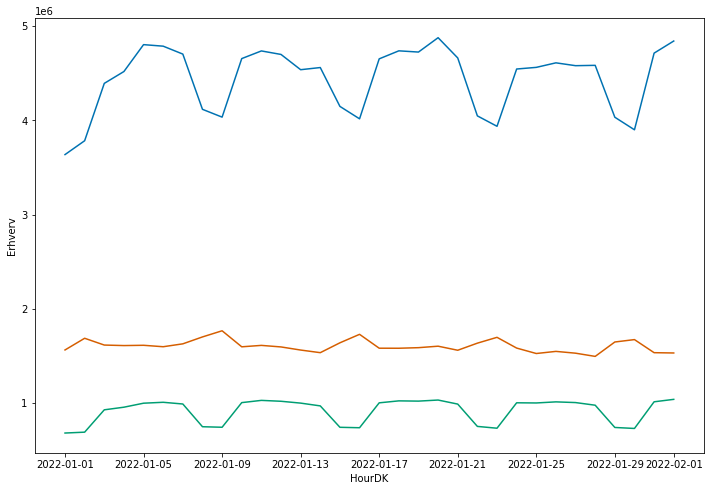

In [147]:
# Month Sample by day
df_day_sample = df_day['01-01-2022':'02-01-2022']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_day_sample, x = df_day_sample.index, y = 'Erhverv', ax = ax)
sns.lineplot(data = df_day_sample, x = df_day_sample.index, y = 'Offentligt', ax = ax)
sns.lineplot(data = df_day_sample, x = df_day_sample.index, y = 'Privat', ax = ax)
plt.show();


mlflow.log_figure(fig, 'Figure_day_complete_sample.png')

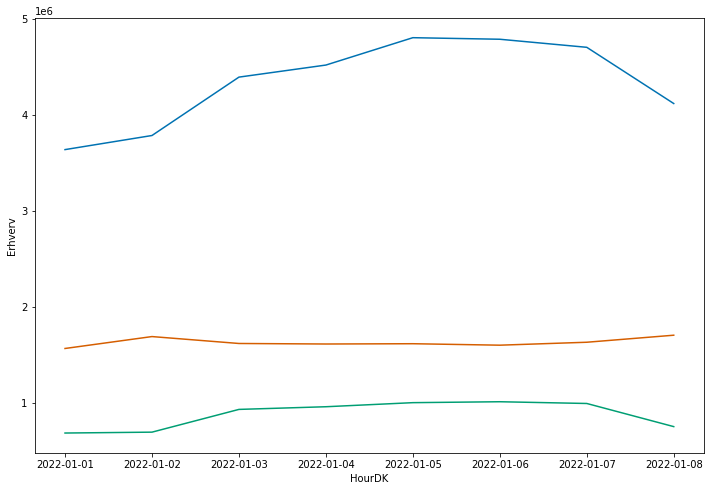

In [148]:
#week sample by day
df_day_sample = df_day['01-01-2022':'01-08-2022']

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(data = df_day_sample, x = df_day_sample.index, y = 'Erhverv', ax = ax)
sns.lineplot(data = df_day_sample, x = df_day_sample.index, y = 'Offentligt', ax = ax)
sns.lineplot(data = df_day_sample, x = df_day_sample.index, y = 'Privat', ax = ax)
plt.show();


mlflow.log_figure(fig, 'Figure_day_complete_sample_week.png')

### 5. Rolling windowns and Sazionality

In [149]:
df_day = df_.set_index('HourDK').resample('D').agg({'ConsumptionkWh': 'sum'})

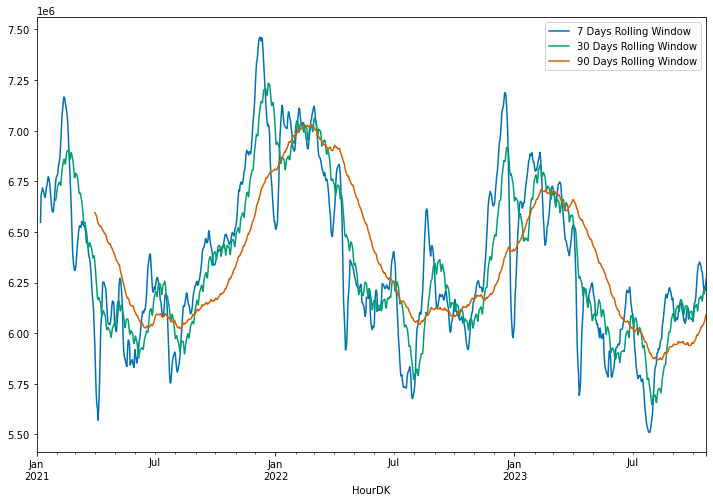

In [150]:
fig, ax = plt.subplots(figsize = (12,8))
df_day.rolling(window= 7).mean().plot(ax = ax)
df_day.rolling(window= 30).mean().plot(ax = ax)
df_day.rolling(window= 90).mean().plot(ax = ax)
ax.legend(['7 Days Rolling Window', '30 Days Rolling Window', '90 Days Rolling Window'])

Evaluating Sazionality by month

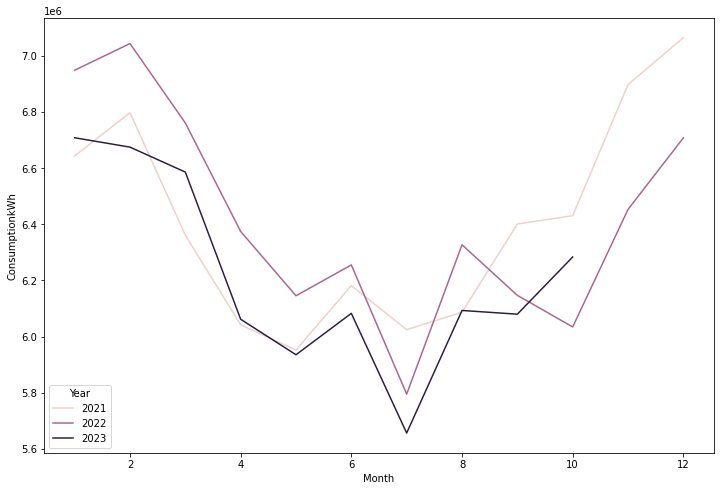

In [151]:
df_season = df_day.groupby([df_day.index.month, df_day.index.year]).mean()
df_season.index = df_season.index.set_names(['Month', 'Year'])
df_season.reset_index(inplace=True)

plt.figure(figsize=(12,8))
sns.lineplot(data = df_season, x = 'Month', hue='Year', y = 'ConsumptionkWh')
plt.show();

Evaluating Sazionality by day of the month

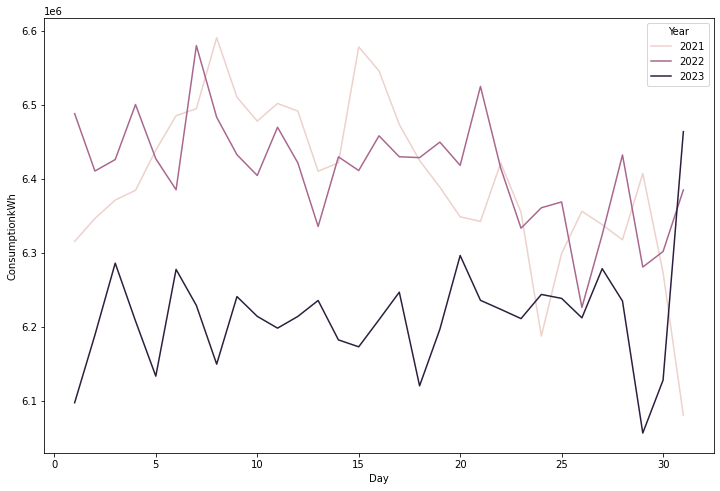

In [152]:
df_season = df_day.groupby([df_day.index.day, df_day.index.year]).mean()
df_season.index = df_season.index.set_names(['Day', 'Year'])
df_season.reset_index(inplace=True)

plt.figure(figsize=(12,8))
sns.lineplot(data = df_season, x = 'Day', hue='Year', y = 'ConsumptionkWh')
plt.show();

Distribuition of the difference

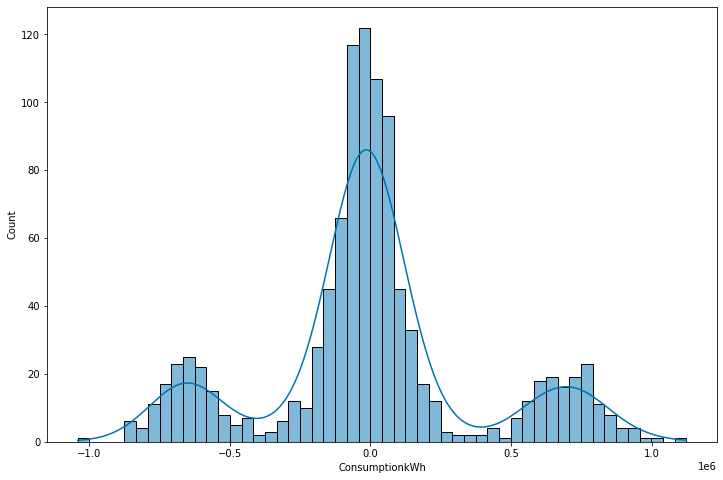

In [153]:
#Histogram of the first difference
fig,ax = plt.subplots(figsize=(12,8))
sns.histplot(data = df_day.diff(1), x = 'ConsumptionkWh', kde = True)
plt.show()

### 6. Time Series Analysis

#### Time Series Decomposition

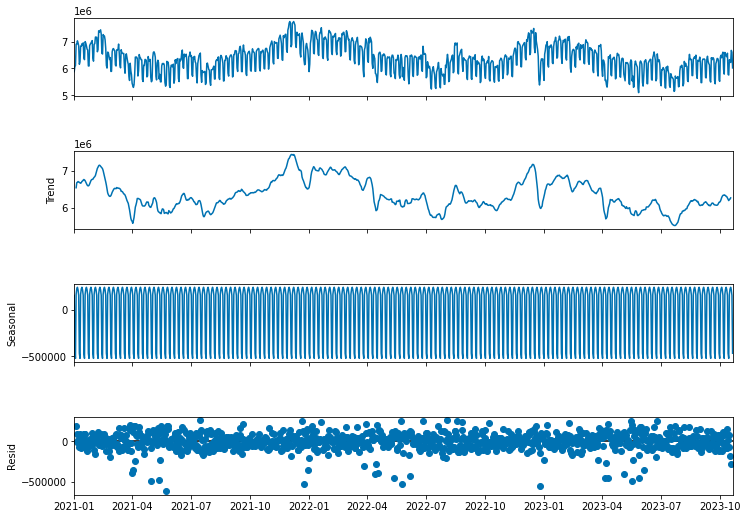

In [156]:
# Time Series Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

# fig,ax = plt.subplots()
result = seasonal_decompose(df_day, model='additive')
fig = result.plot()
fig.set_size_inches(12,8)
plt.show()

mlflow.log_figure(fig, 'decomposition.png')

#### ACF

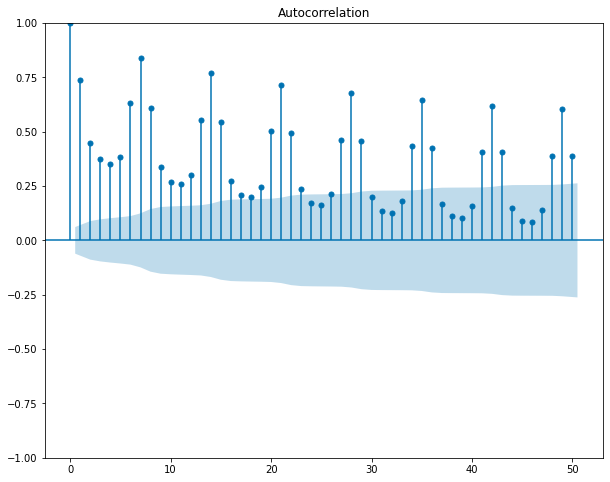

In [157]:
#plotando o gráfico de autocorrelação da serie temporal
import statsmodels.api as sm

fig,ax = plt.subplots(figsize=(10,8))
ax = sm.graphics.tsa.plot_acf(df_day, lags = 50, alpha = 0.05, ax = ax)
plt.show()

#It looks like the influence is decreasing, to have a better look at this we must have a pacf graph as well

### PACF

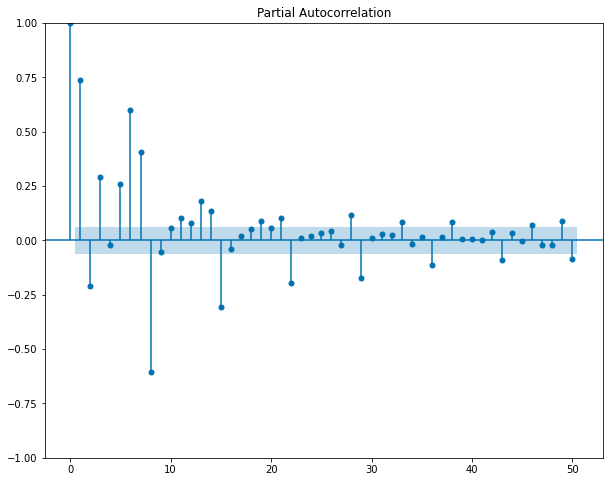

In [158]:
#plotando o gráfico de autocorrelação parcial da serie temporal
import statsmodels.api as sm

fig,ax = plt.subplots(figsize=(10,8))
ax = sm.graphics.tsa.plot_pacf(df_day, lags = 50, alpha = 0.05, ax = ax)
plt.show()



looks like a ARMA model, no cut-off point on ACF or PACF

adfuller test for stationarity

In [159]:
# Vamos fazer um teste de estacionariedade para avaliar a serie temporal
results = sm.tsa.stattools.adfuller(df_day)
results[1]
#Como o valor de p-value é muito maior que 0.05 rejeitamos a hipotese nula de que os daddos não são uma serie não estacionaria. Assumimos então a estacionariedade.

0.030014435054097104

Testing for an ARMA Model - > lowest AIC Value

In [186]:
l = list()
for x in range(8):
    for y in range(8):
        model = sm.tsa.ARIMA(df_day, order = (x,0,y))
        results = model.fit()
        l.append((results.aic, (x, y)))


c:\Users\degio\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\degio\anaconda3\lib\site-packa

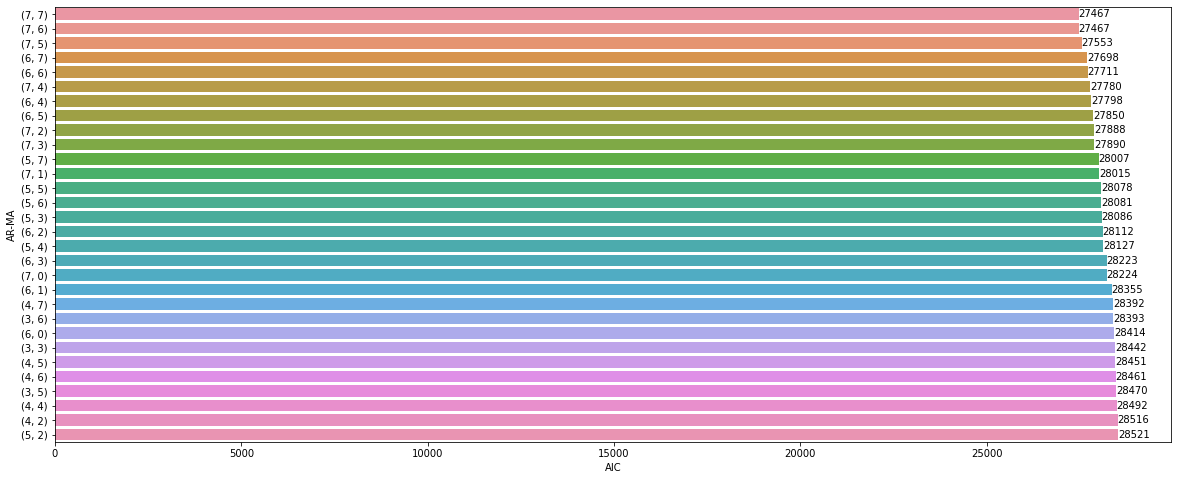

In [213]:
l = pd.DataFrame(l, columns= ['AIC', 'AR-MA'])
plt.figure(figsize = (20,8))
ax = sns.barplot(data = l.sort_values('AIC').head(30), y = 'AR-MA', x='AIC')
ax.bar_label(ax.containers[0], fmt='%.0f');

Testing the modeling for an ARMA model for the best paramters found

In [220]:
#Testando um ajuste de modelo autoregressivo de primeira ordem

#Fiz o limite de data para realizar o teste
model = sm.tsa.ARIMA(df_day[:'2023-06-01'], order = (7,0,7))
results = model.fit()

c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [221]:
results.summary(), results.params

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:         ConsumptionkWh   No. Observations:                  882
 Model:                 ARIMA(7, 0, 7)   Log Likelihood              -11839.076
 Date:                Mon, 30 Oct 2023   AIC                          23710.152
 Time:                        23:24:44   BIC                          23786.667
 Sample:                    01-01-2021   HQIC                         23739.410
                          - 06-01-2023                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const       6.405e+06   3.47e-09   1.84e+15      0.000    6.41e+06    6.41e+06
 ar.L1          0.0328      0.029      1.129      0.259      -0.024   

Forecasting whit this model

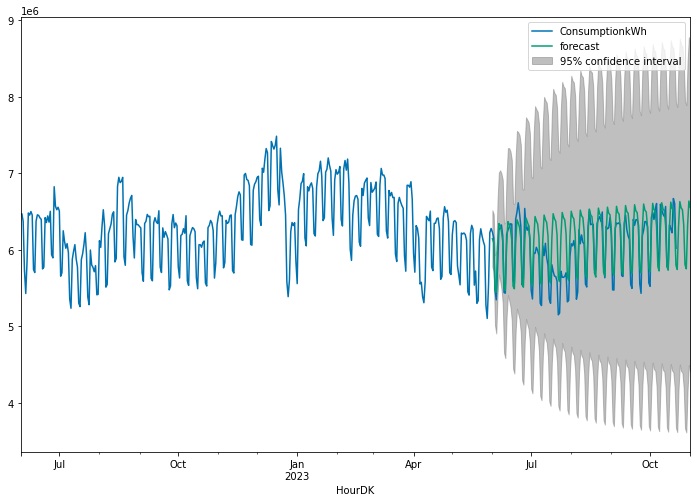

In [227]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots(figsize = (12,8))
df_day['2022-06-01':].plot(ax = ax)
plot_predict(results, '2023-06-01','2023-11-01', alpha = 0.05, ax = ax)
plt.show()

In [210]:
mlflow.end_run()